In [64]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import kagglehub
from pathlib import Path
from PIL import Image
import numpy as np
from collections import defaultdict

In [65]:
# Download latest version
base_path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", base_path)

Path to dataset files: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [66]:
def explore_filepath(filepath):
    for dirpath, dirnames, filenames in os.walk(filepath):
        print(f"Current directory: {dirpath}")
        print(f"Subdirectories: {dirnames}")
        print(f"Files: {filenames}", end = '\n----------\n')

#the test and train folders in the path/chest_xray directory are the same as the test and train folders in the path directory

explore_filepath(base_path)

Current directory: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2
Subdirectories: ['chest_xray']
Files: []
----------
Current directory: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray
Subdirectories: ['chest_xray', 'test', 'train', 'val', '__MACOSX']
Files: []
----------
Current directory: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray
Subdirectories: ['test', 'train', 'val']
Files: ['.DS_Store']
----------
Current directory: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test
Subdirectories: ['NORMAL', 'PNEUMONIA']
Files: ['.DS_Store']
----------
Current directory: C:\Users\mihir\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2\chest_xray\chest_xray\test\NORMAL
Subdirectories: []
Files: ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'I

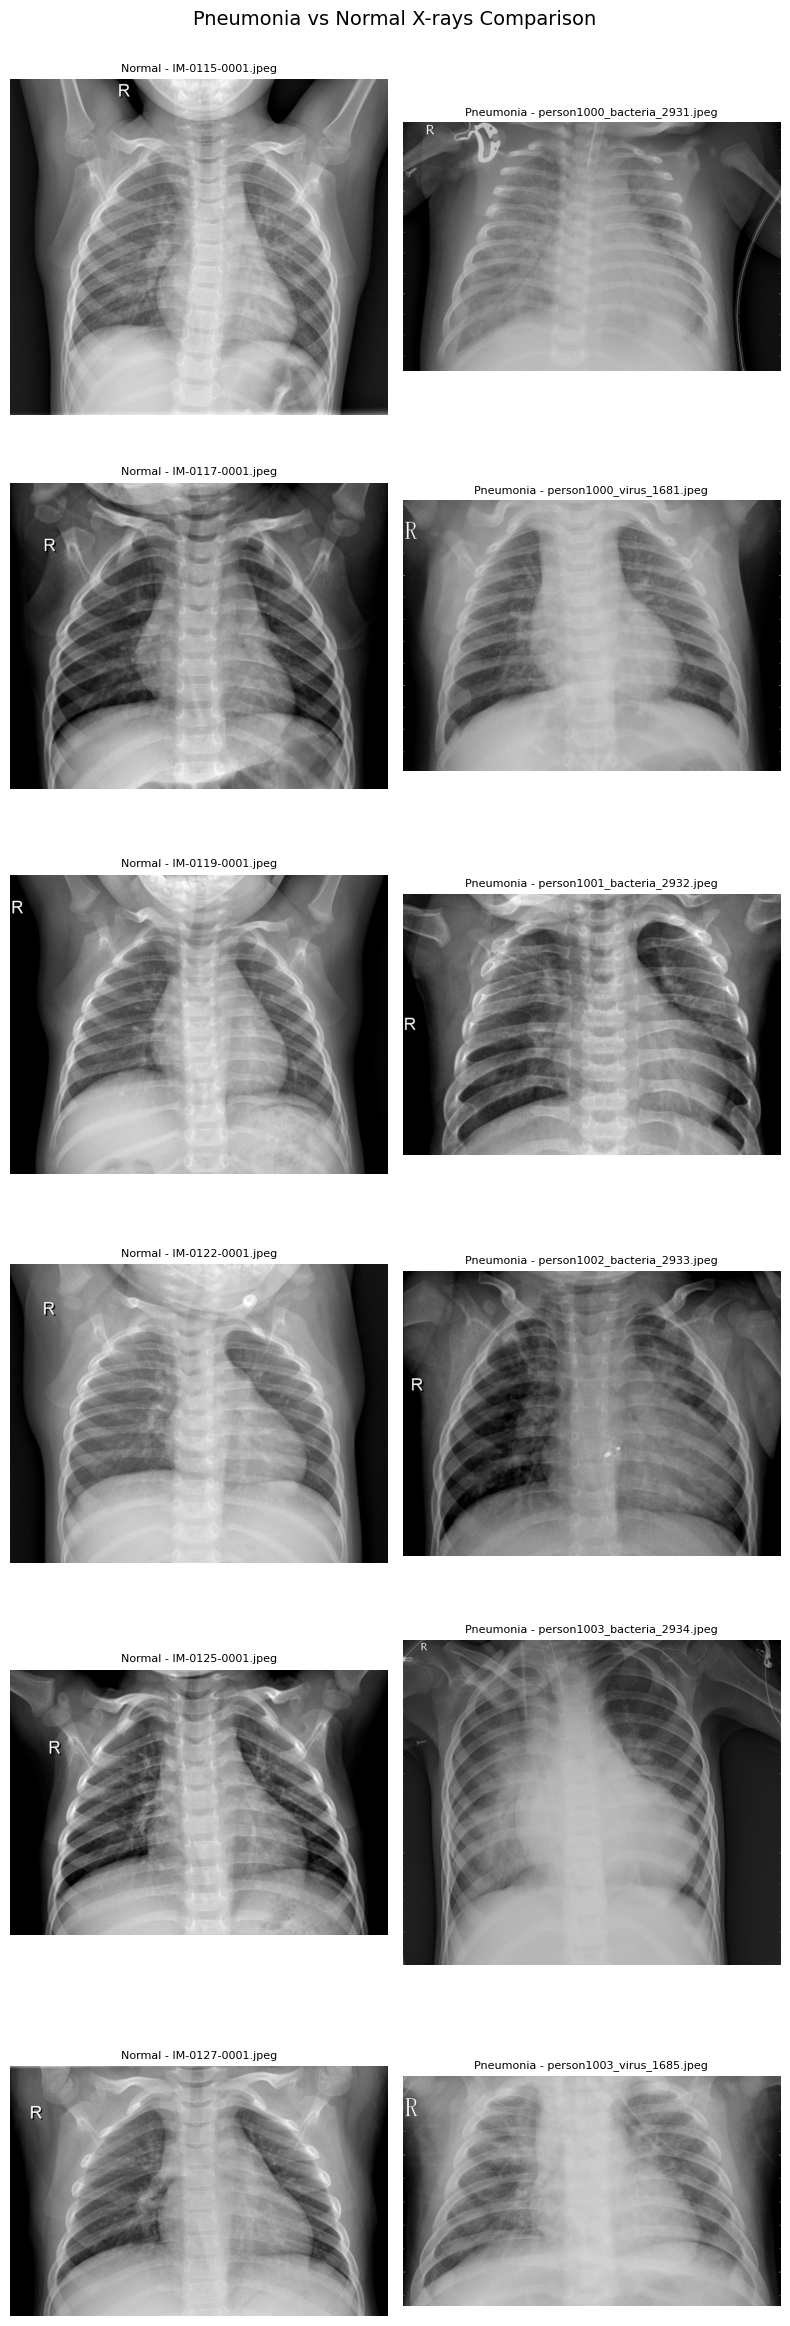

In [67]:
#Side by side image comparison of pneumonia and normal xrays

def display_pneumonia_vs_normal(normal_img_folder: Path, pneumonia_img_folder: Path, n_samples: int = 6):
    fig, axs = plt.subplots(nrows=n_samples, ncols=2, figsize=(2*4, n_samples*4))
    
    pneumonia_img_paths = list(pneumonia_img_folder.glob('*.jpeg'))[:n_samples]
    normal_img_paths = list(normal_img_folder.glob('*.jpeg'))[:n_samples]
    
    for i, path in enumerate(normal_img_paths):
        img = mpimg.imread(path)
        axs[i, 0].axis('off') #turns off the tick marks and labels for the x and y axis
        axs[i, 0].imshow(img, cmap='gray')
        axs[i, 0].set_title(f'Normal - {path.name}', fontsize=8)
    
    for i, path in enumerate(pneumonia_img_paths):
        img = mpimg.imread(path)
        axs[i, 1].axis('off') #turns off the tick marks and labels for the x and y axis
        axs[i, 1].imshow(img, cmap='gray') #cmap = 'gray' displays the image in grayscale
        axs[i, 1].set_title(f'Pneumonia - {path.name}', fontsize=8)

    plt.suptitle('Pneumonia vs Normal X-rays Comparison', fontsize=14, y=0.995)
    plt.tight_layout() 
    plt.show()

#display the first 6 pneumonia iamges
normal_img_folder = Path(base_path)/'chest_xray'/'train'/'NORMAL'
pneumonia_img_folder = Path(base_path)/'chest_xray'/'train'/'PNEUMONIA'

display_pneumonia_vs_normal(normal_img_folder = normal_img_folder, pneumonia_img_folder = pneumonia_img_folder)

Text(0, 0.5, 'Number of Images')

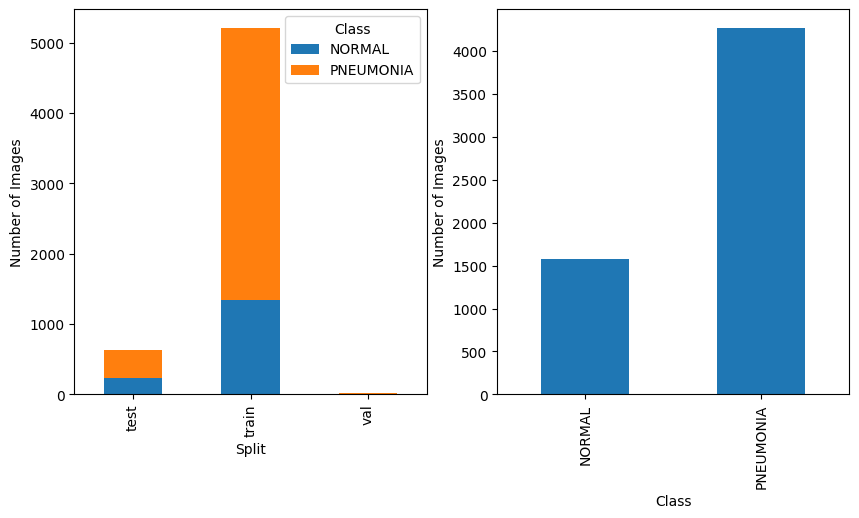

In [68]:
#Class distribution analysis

def create_class_distribution_df(base_path):
    data_splits = ['train', 'test', 'val']
    classes = ['NORMAL', 'PNEUMONIA']
    
    data = defaultdict(list)

    for split in data_splits:
        for class_name in classes:
            bp = Path(base_path)/'chest_xray'/split/class_name
            count = len(list(bp.glob('*.jpeg'))) if bp.exists() else 0
            data['Split'].append(split)
            data['Class'].append(class_name)
            data['Count'].append(count)
            #data is a df with auto indices, and columns are split, class, and count

    df = pd.DataFrame(data)
    pivoted_df = df.pivot(index = 'Split', columns = 'Class', values = 'Count')

    pivoted_df['Total per split'] = pivoted_df.sum(axis = 1) #Total adds up the number of images in each row (the total number of images for test/train)

    return df, pivoted_df

df_dist, pivot_dist = create_class_distribution_df(base_path)
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))

#there is a bar for each index (test/train/val). The height of each segment within a bar is the column value for that index
pivot_dist.loc[:, ['NORMAL', 'PNEUMONIA']].plot(kind = 'bar', stacked = True, ax = ax[0])


pivot_df_2 = df_dist.pivot(index = 'Class', columns = 'Split', values = 'Count')
pivot_df_2['Total'] = pivot_df_2.sum(axis=1)
#plot only the total number images for each class (pneumonia or normal)
pivot_df_2['Total'].plot(kind = 'bar', ax = ax[1])

ax[0].set_ylabel('Number of Images')
ax[1].set_ylabel('Number of Images')        

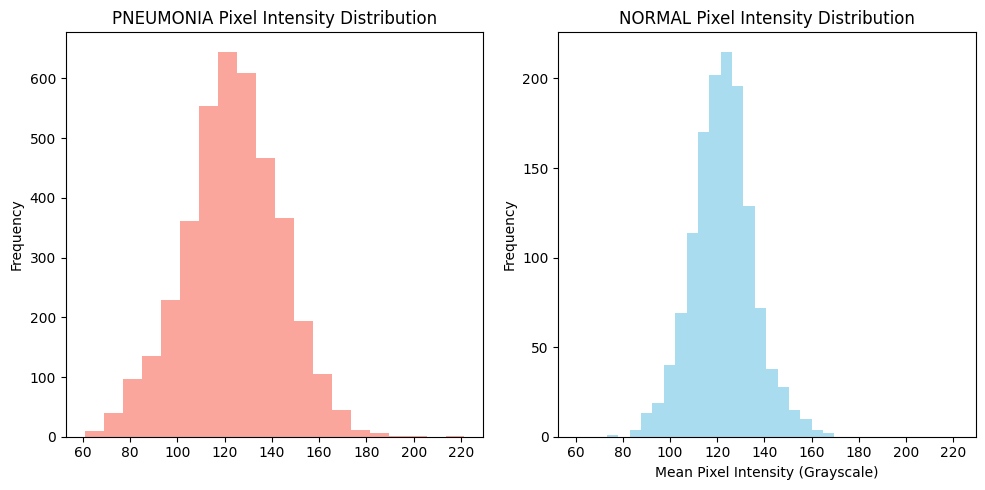

In [69]:
#Pixel value analysis

def analyze_image_properties(base_path):
    stats = defaultdict(list)
    
    pneumonia_paths = list((Path(base_path)/'chest_xray'/'train'/'PNEUMONIA').glob('*.jpeg'))
    normal_paths = list((Path(base_path)/'chest_xray'/'train'/'NORMAL').glob('*.jpeg'))

    for pneumonia_img in pneumonia_paths:
        with Image.open(pneumonia_img) as img:
            grayscale_img = img.convert('L')
            mean_intensity = np.array(grayscale_img).mean()
            stats['mean_pixel_value'].append(mean_intensity)
            stats['class'].append('PNEUMONIA')

    for normal_img in normal_paths:
        with Image.open(normal_img) as img:
            grayscale_img = img.convert('L')
            mean_intensity = np.array(grayscale_img).mean()
            stats['mean_pixel_value'].append(mean_intensity)
            stats['class'].append('NORMAL')

   
    df = pd.DataFrame(stats)
    #creates a dataframe with default indices, and columns are mean_pixel_value and class

    return df

df = analyze_image_properties(base_path)
classes =  ['PNEUMONIA', 'NORMAL']

fig, axes = plt.subplots(1, 2, figsize = (10, 5), sharex = True) #sharex = True means that the x-axis will be the same for all subplots
colors = ['salmon', 'skyblue']

for ax, class_name, color in zip(axes, classes, colors):
    subset = df[df['class'] == class_name]
    ax.hist(subset['mean_pixel_value'], bins=20, alpha=0.7, color=color)
    ax.set_ylabel('Frequency')
    ax.set_title(f'{class_name} Pixel Intensity Distribution')

axes[-1].set_xlabel('Mean Pixel Intensity (Grayscale)')

plt.tight_layout()
plt.show()